In [2]:
#@title Imports

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
from tqdm.notebook import tqdm
import scipy.stats
from sklearn.linear_model import LinearRegression
import rasterio
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Shape: (2000, 2000)
Unique values: [ 0 11 12 13 14 15 18] 



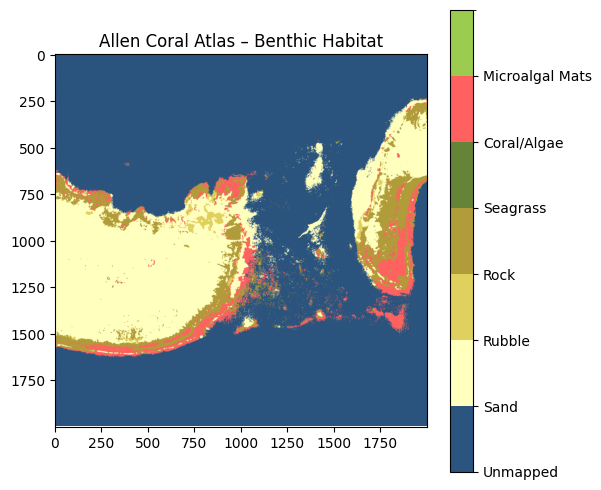

In [3]:
#@title Loading and Visualizing Data

with rasterio.open("heron_sykes_reef.tif") as src:
    data = src.read(1)

# shaping the data as a square
n = 2000
data = data[:n, :n]


print("Shape:", data.shape)
print("Unique values:", np.unique(data), "\n")


# matching colors with the Allen Atlas
values = [0, 11, 12, 13, 14, 15, 18]
colors = [
    "#2B547E",  # 0 Unmapped
    "#ffffbe",  # 11 Sand
    "#e0d05e",  # 12 Rubble
    "#b19c3a",  # 13 Rock
    "#668438",  # 14 Seagrass
    "#ff6161",  # 15 Coral/Algae
    "#9bcc4f"   # 18 Microalgal Mats
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(values + [max(values) + 1], cmap.N)

plt.figure(figsize=(6, 6))
img = plt.imshow(data, cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ticks=values)
cbar.ax.set_yticklabels([
    "Unmapped",
    "Sand",
    "Rubble",
    "Rock",
    "Seagrass",
    "Coral/Algae",
    "Microalgal Mats"
])
plt.title('Allen Coral Atlas – Benthic Habitat')
plt.axis('on')
plt.show()

Shape: (200, 200) 



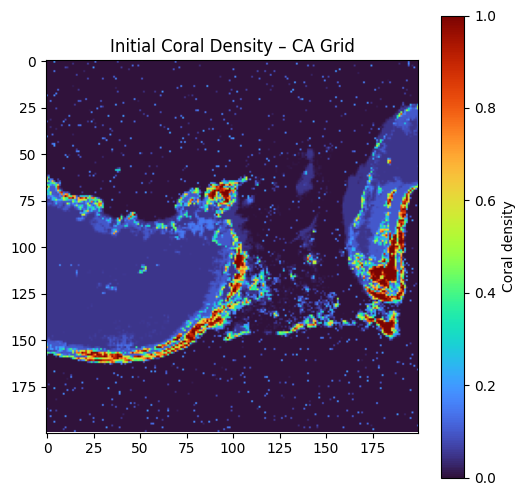

In [4]:
#@title Converting into Cellular Automata

def coral_fraction(values):
    """
    Convert benthic class values to coral fraction [0,1].
    """
    frac = np.zeros_like(values, dtype=float)

    frac[values == 15] = 1.0    # Coral / algae
    frac[values == 18] = 0.3    # Microalgal mats
    frac[values == 14] = 0.2    # Seagrass
    frac[values == 13] = 0.1    # Rock
    frac[values == 12] = 0.15   # Rubble
    frac[values == 11] = 0.05   # Sand


    return frac


rng = np.random.default_rng(seed=42)  # reproducibility
coral_density_init = coral_fraction(data)


def aggregate_to_ca_grid(density, rng, cell_size=10):
    n = density.shape[0]
    h = n // cell_size
    w = n // cell_size

    # trim to ensure divisibility by the cell size
    trimmed = density[:h*cell_size, :w*cell_size]

    # condensing the data into a 200 x 200 grid by calculating the weighted averages
    # of each 10 x 10 square based on the contributions of each benthic class
    ca_grid = trimmed.reshape(
        h, cell_size,
        w, cell_size
    ).mean(axis=(1, 3))

    # Unmapped: 3% chance of coral presence, random 1–20%
    unmapped = (ca_grid == 0)
    random_presence = rng.random(ca_grid.shape) < 0.03
    ca_grid[unmapped & random_presence] = rng.uniform(0.01, 0.2, size=np.sum(unmapped & random_presence))

    return ca_grid


ca_grid = aggregate_to_ca_grid(coral_density_init, rng, cell_size=10)
print("Shape:", ca_grid.shape, "\n")  # (200, 200)


plt.figure(figsize=(6,6))
plt.imshow(ca_grid, cmap='turbo')
plt.colorbar(label='Coral density')
plt.title('Initial Coral Density – CA Grid')
plt.axis('on')
plt.show()


In [5]:
#@title Simulation and Animation

# animation code reused from "Implementation and Analysis" assignment
def make_animation(sim, total_frames, steps_per_frame=1, interval=100):
    def update(frame_number):
        for _ in range(steps_per_frame):
            sim.update()
        progress_bar.update(1)
        return sim.observe()

    sim.initialize()
    progress_bar = tqdm(total=total_frames, desc="Plotting System Visualization")
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames, interval=interval)
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    return output


class CoralBleachSim:
  """
  2D cellular automata model of coral reef bleaching driven by
  temperature stress, ocean acidification, and agricultural runoff pollution.

  Time step
  ---------
  One simulation update corresponds to one week.

  Attributes
  ----------
  coral_init : array (n x n)
        Initial coral density grid, with values in [0, 1], converted from real
        benthic habitat data and aggregated into the cellular automata.

  n : int
      Grid size.

  coral : array (n x n)
      Current coral density in each cell.

  bleached : array (n x n)
      Fraction of coral in each cell that is currently bleached (from 0 (no bleaching)
      to 1 (fully bleached)).

  bleach_time : array (n x n)
      Number of consecutive weeks that each cell has been in a bleached state.

  pollution : array (n x n)
      Concentration of agricultural runoff pollution in each cell.

  step_counter : int
      Number of simulation steps (weeks) completed.

  heat_stress : float
      Accumulated temperature stress due to positive temperature anomalies.

  acidification : float
      Global ocean acidification level which increases slowly over time.

  rng : numpy.random.Generator
      Random number generator used for the stochastic processes in the model.

  Parameters
  ----------
  temp_sigma : float
        Standard deviation of weekly temperature anomalies.

  temp_threshold : float
      Temperature anomaly threshold above which heat stress adds up.

  acid_init : float
      Initial ocean acidification level.

  acid_rate : float
      Weekly increase in ocean acidification.

  alpha : float
      Sensitivity of bleaching probability to accumulated heat stress.

  beta : float
      Sensitivity of bleaching probability to ocean acidification.

  gamma : float
      Sensitivity of bleaching probability to local pollution concentration.

  bleach_rate : float
      Rate at which the bleached fraction increases during bleaching events.

  recovery_rate : float
      Rate at which the bleached fraction decreases during recovery.

  bleach_crit : float
      Critical bleached fraction above which prolonged bleaching leads to coral mortality.

  death_period : int
      Number of consecutive weeks a cell needs to be bleached before coral mortality occurs.

  death_rate : float
      Fraction of coral density lost per week once mortality conditions are met.

  growth_rate : float
      Small logistic growth rate for coral recovery in healthy cells that already contain coral.

  pollution_inflow : float
      Maximum weekly pollution inflow added to each cell along the left boundary.

  pollution_diffusion : float
      Fraction of pollution that diffuses to neighboring cells each week.

  pollution_decay : float
      Fraction of pollution that decays each week.

  pollution_percent : float
      Fraction of cells that receive pollution inflow.

  plotting : bool
      If True, creates matplotlib figures for visualization and animation.

  Methods
  -------
  initialize():
      Initializes the arrays describing the coral density, bleaching
      fraction, bleaching duration, pollution concentration, and global
      environmental variables.

  update():
      Updates the coral density, bleaching fraction, bleaching duration,
      pollution concentration, and global environmental variables.

  observe():
      Produces a visualization of the current simulation state, showing coral
      density with bleached corals and a separate visualization for pollution
      moving through the system.

  ...
  """

  def __init__(
      self,
      coral_init,
      plotting=True,

      # temperature
      temp_sigma=0.5,
      temp_threshold=2,

      # acidification
      acid_init=0.0,
      acid_rate=0.0005,

      # bleaching sensitivity
      alpha=0.8,   # heat
      beta=300,    # acidification
      gamma=150,   # pollution

      # bleaching dynamics
      bleach_rate=0.45,
      recovery_rate=0.25,

      # death
      bleach_crit=0.8,
      death_period=16,     # weeks
      death_rate=0.05,

      # coral growth
      growth_rate=0.1,

      # pollution
      pollution_inflow=0.5,
      pollution_percent=0.25,
      pollution_diffusion=0.95,
      pollution_decay=0.05,

      # stress
      stress_threshold=0.05,
  ):
      self.coral_init = coral_init
      self.n = coral_init.shape[0]
      self.plotting = plotting

      # parameters
      self.temp_sigma = temp_sigma
      self.temp_threshold = temp_threshold
      self.acid_init = acid_init
      self.acid_rate = acid_rate
      self.alpha = alpha
      self.beta = beta
      self.gamma = gamma
      self.bleach_rate = bleach_rate
      self.recovery_rate = recovery_rate
      self.bleach_crit = bleach_crit
      self.death_period = death_period
      self.death_rate = death_rate
      self.growth_rate = growth_rate
      self.pollution_inflow = pollution_inflow
      self.pollution_diffusion = pollution_diffusion
      self.pollution_decay = pollution_decay
      self.pollution_percent = pollution_percent
      self.stress_threshold = stress_threshold

      # RNG
      self.rng = np.random.default_rng()

      if plotting:
          self.figure, self.axes = plt.subplots(1, 2, figsize=(10, 4))


  def initialize(self):
      self.coral = copy.copy(self.coral_init)
      self.bleached = np.zeros_like(self.coral)
      self.bleach_time = np.zeros_like(self.coral, dtype=int)
      self.pollution = np.zeros_like(self.coral)
      self.step_counter = 0
      self.heat_stress = 0.0
      self.acidification = 0
      self.pollution_sources = (self.rng.random(self.n) < self.pollution_percent)

      mask = (self.rng.random(self.pollution.shape) < 0.25)
      self.pollution[mask] = self.rng.uniform(0.01, 0.35, size=mask.sum())


  def shift_zero(self, A, di, dj):
    """
    Shift array A by (di, dj) with 0 padding (no wrap).
    di > 0 shifts down, di < 0 shifts up
    dj > 0 shifts right, dj < 0 shifts left
    """
    out = np.zeros_like(A)
    n, m = A.shape

    i0_src = max(0, -di)
    i1_src = min(n, n - di)
    j0_src = max(0, -dj)
    j1_src = min(m, m - dj)

    i0_dst = max(0, di)
    i1_dst = min(n, n + di)
    j0_dst = max(0, dj)
    j1_dst = min(m, m + dj)

    out[i0_dst:i1_dst, j0_dst:j1_dst] = A[i0_src:i1_src, j0_src:j1_src]
    return out



  def observe(self):
      ax_coral, ax_poll = self.axes
      ax_coral.clear()
      ax_poll.clear()

      # coral densities
      img = ax_coral.imshow(self.coral, cmap="turbo", vmin=0, vmax=1)

      # bleaching (white overlay with transparency = bleached_amount)
      bleached_amount = np.clip(self.coral * self.bleached, 0, 1)

      overlay = np.zeros((*bleached_amount.shape, 4), dtype=float)
      overlay[..., 0:3] = 1.0                       # white RGB
      overlay[..., 3] = 0.9 * bleached_amount       # alpha channel (transparent if 0)

      ax_coral.imshow(overlay, interpolation="nearest")

      ax_coral.set_title(f"Coral bleaching (week {self.step_counter})")
      ax_coral.axis("off")

      # pollution
      ax_poll.imshow(self.pollution, cmap="YlOrBr", vmin=0, vmax=0.25, interpolation="nearest")
      ax_poll.set_title("Agricultural runoff pollution")
      ax_poll.axis("off")

      return []


  def update(self):
    # --- 1. temperature anomaly & heat stress ---
    delta_t = self.rng.normal(0, self.temp_sigma)
    if delta_t - self.temp_threshold < 0:
        self.heat_stress = 0
    else:
        self.heat_stress = max(
            0,
            self.heat_stress + delta_t - self.temp_threshold
        )


    # --- 2. acidifaction ---
    self.acidification += self.acid_rate


    # --- 3. pollution addition (random sources each week) ---
    sources = (self.rng.random(self.n) < self.pollution_percent)

    inflow = self.rng.uniform(0, self.pollution_inflow, size=self.n)
    inflow *= sources.astype(float)

    self.pollution[:, 0] += inflow


    # --- 4. pollution transport (ONLY left -> right, fixed boundaries) ---
    d = self.pollution_diffusion
    P = self.pollution

    # Incoming at (i, j) comes only from (i, j-1)
    incoming = self.shift_zero(P, 0, +1)   # P[i, j-1] -> P[i, j]

    # Update: keep (1-d) locally, move fraction d from left neighbor
    self.pollution = (1 - d) * P + incoming


    # --- 5. pollution decay ---
    self.pollution *= (1 - self.pollution_decay)


    # --- 6. bleaching probability ---
    stress = (
        self.alpha * self.heat_stress +
        self.beta * self.acidification +
        self.gamma * self.pollution
    )
    # logistic bleaching
    p_bleach = 1 / (1 + np.exp(-0.03*(stress - self.stress_threshold)))
    p_bleach = np.clip(p_bleach, 0, 1)     # ensuring the probability is between 0 and 1
    bleaching_events = self.rng.random(self.coral.shape) < p_bleach


    # --- 7. bleached fractions ---
    self.bleached[bleaching_events] = np.minimum(
        1,
        self.bleached[bleaching_events] + self.bleach_rate
    )

    # considering the recoveries
    self.bleached[~bleaching_events] = np.maximum(
        0,
        self.bleached[~bleaching_events] - self.recovery_rate
    )


    # --- 8. bleaching duration ---
    bleached_now = self.bleached > 0
    self.bleach_time[bleached_now] += 1
    self.bleach_time[~bleached_now] = 0


    # --- 9. death after prolonged bleaching ---
    dying = (
        (self.bleached > self.bleach_crit) &
        (self.bleach_time > self.death_period)
    )

    self.coral[dying] *= (1 - self.death_rate)


    # --- 10. coral regrowth (only healthy cells) ---
    healthy = (self.coral > 0) & (self.bleached == 0)
    self.coral[healthy] += self.growth_rate * self.coral[healthy] * (1 - self.coral[healthy])


    # keeping density bounds between 0 and 1
    self.coral = np.clip(self.coral, 0, 1)

    # updating step counter
    self.step_counter += 1



# running the simulation
sim = CoralBleachSim(ca_grid, plotting=True)
sim.initialize()
make_animation(sim, total_frames=200, steps_per_frame=1, interval=120)


Plotting System Visualization:   0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 1000x400 with 0 Axes>

In [6]:
#@title Test Cases

# initiating a small grid with corals everywhere for testing
n = 20
coral_init_test = np.full((n, n), 0.6, dtype=float)

# Test 1: checking for correct initialization of the grid
sim1 = CoralBleachSim(
    coral_init_test,
    plotting=False,
    pollution_inflow=0.0,        # no inflow
)

sim1.initialize()

assert sim1.coral.shape == (n, n)
assert sim1.bleached.shape == (n, n)
assert sim1.pollution.shape == (n, n)

assert np.all((sim1.coral >= 0) & (sim1.coral <= 1))
assert np.all((sim1.bleached >= 0) & (sim1.bleached <= 1))
assert np.all(sim1.pollution >= 0)

print("Test 1 passed: init shapes and bounds OK.")


# Test 2: acidifaction increases correctly
sim2 = CoralBleachSim(
    coral_init_test,
    plotting=False,
    pollution_inflow=0.0,
    acid_init=0.1,
    acid_rate=0.002,
    temp_sigma=0.0,
)

sim2.initialize()
a0 = sim2.acidification
sim2.update()
a1 = sim2.acidification
sim2.update()
a2 = sim2.acidification

assert np.isclose(a1 - a0, sim2.acid_rate)
assert np.isclose(a2 - a1, sim2.acid_rate)

print("Test 2 passed: acidification increments correctly.")


# Test 3: ensuring that heat stress is always positive
sim3 = CoralBleachSim(
    coral_init_test,
    plotting=False,
    pollution_inflow=0.0,
    temp_sigma=5.0,        # large noise
    temp_threshold=0.5,
)

sim3.initialize()
for _ in range(50):
    sim3.update()
    assert sim3.heat_stress >= 0

print("Test 3 passed: heat_stress is nonnegative over many steps.")


# Test 4: recovery happens when stress is low
sim4 = CoralBleachSim(
    coral_init_test,
    plotting=False,
    temp_sigma=0.0,
    acid_rate=0.0,
    alpha=0.0, beta=0.0, gamma=0.0,
    stress_threshold=10.0,
    bleach_rate=0,
    recovery_rate=0.25,
    growth_rate=0.0,
    pollution_inflow=0.0,
    pollution_decay=0.0,
    pollution_diffusion=0.0,
)

sim4.initialize()

# remove initial pollution
sim4.pollution[:] = 0.0

# force a bleached state, then confirm it recovers
sim4.bleached[:] = 0.8
b0 = sim4.bleached.mean()

sim4.update()
b1 = sim4.bleached.mean()

for _ in range(50):
    sim4.update()
    b0 = b1
    b1 = sim4.bleached.mean()
    assert b1 <= b0

print("Test 4 passed: bleaching decreases (recovery) when stress is off.")

# Test 5: coral mortality happens only after long-enough bleached period
sim5 = CoralBleachSim(
    coral_init_test,
    plotting=False,
    temp_sigma=0.0,
    acid_rate=0.0,
    alpha=0.0, beta=0.0, gamma=0.0,
    stress_threshold=-10.0,
    bleach_rate=1.0,
    recovery_rate=0.0,
    bleach_crit=0.2,
    death_period=2,
    death_rate=0.5,
    growth_rate=0.0,
    pollution_inflow=0.0,
    pollution_decay=0.0,
    pollution_diffusion=0.0,
)

sim5.initialize()
sim5.pollution[:] = 0.0

c0 = sim5.coral.mean()

sim5.update()
c1 = sim5.coral.mean()
sim5.update()
c2 = sim5.coral.mean()

sim5.update()
c3 = sim5.coral.mean()

assert np.isclose(c1, c0, atol=1e-6), "Coral should not die immediately."
assert np.isclose(c2, c0, atol=1e-6), "Coral should not die before death_period is exceeded."
assert c3 < c0, "Coral should decline once prolonged bleaching condition is met."

print("Test 7 passed: mortality only occurs after prolonged bleaching.")

Test 1 passed: init shapes and bounds OK.
Test 2 passed: acidification increments correctly.
Test 3 passed: heat_stress is nonnegative over many steps.
Test 4 passed: bleaching decreases (recovery) when stress is off.
Test 7 passed: mortality only occurs after prolonged bleaching.


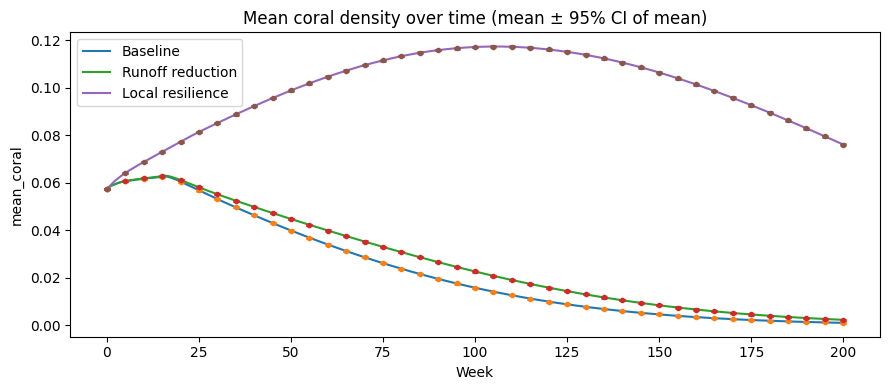

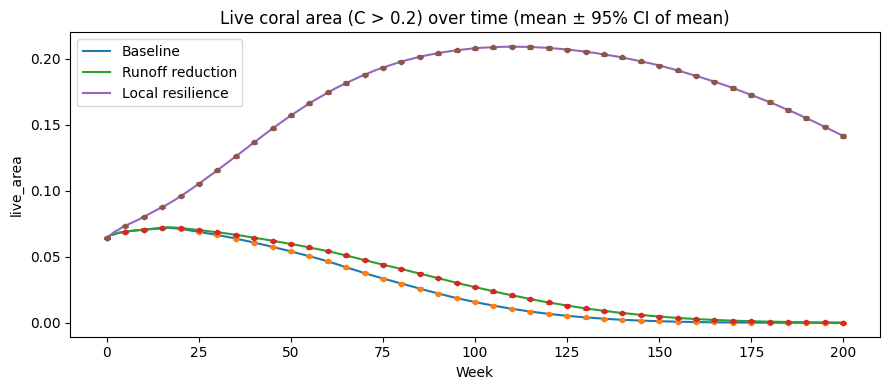

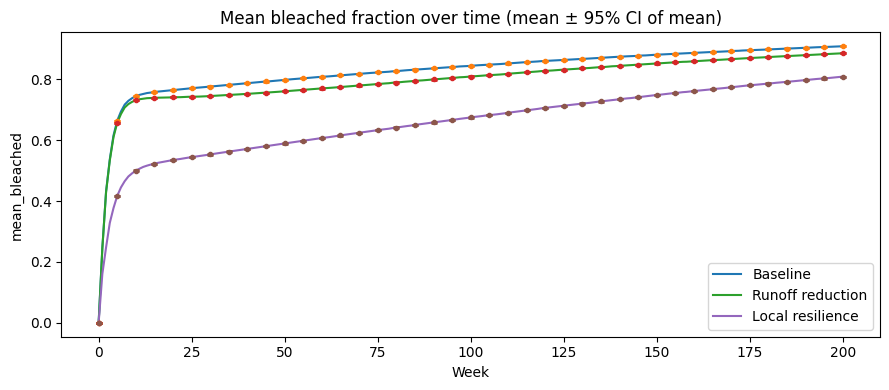

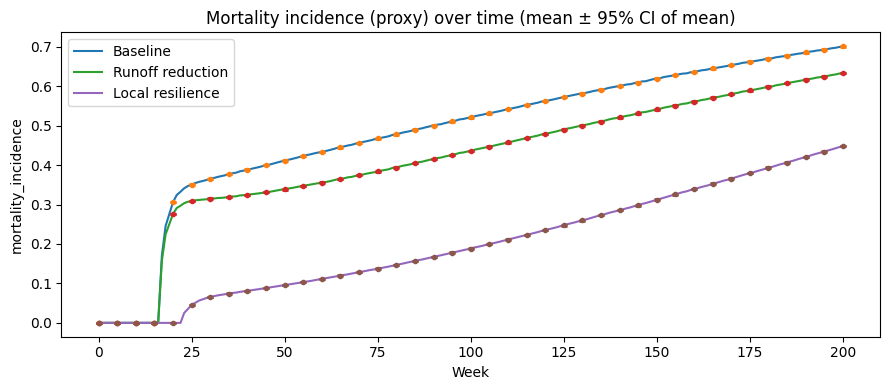

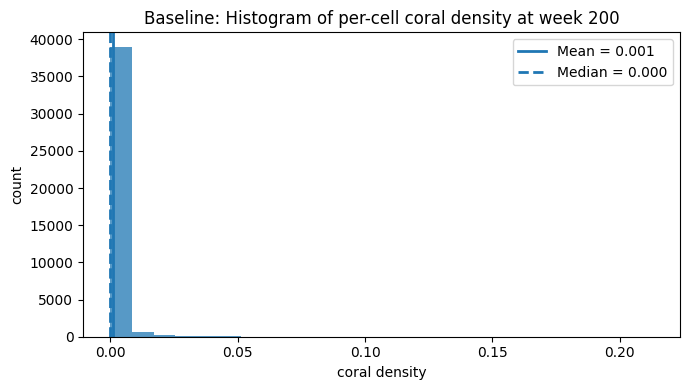

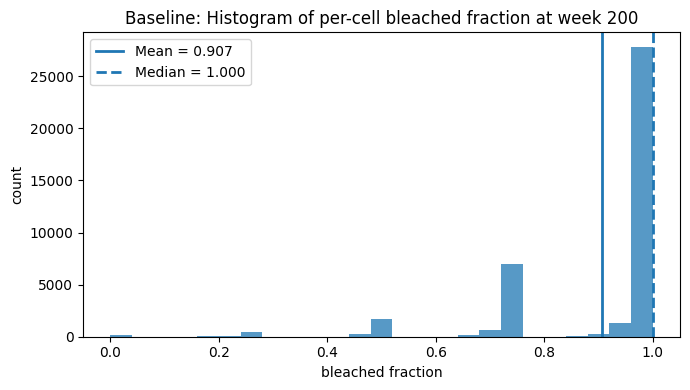

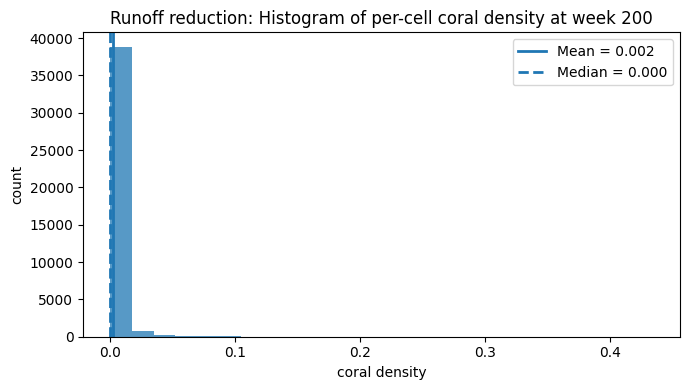

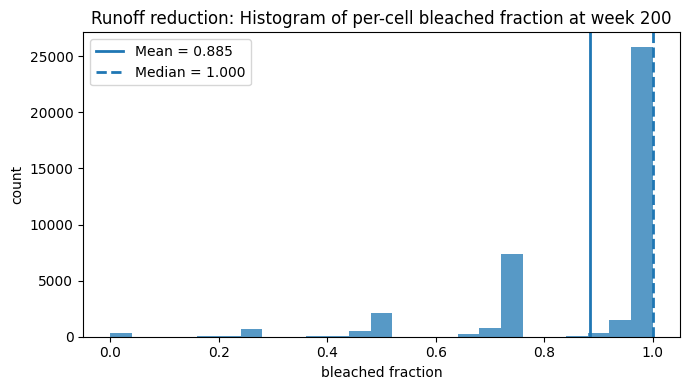

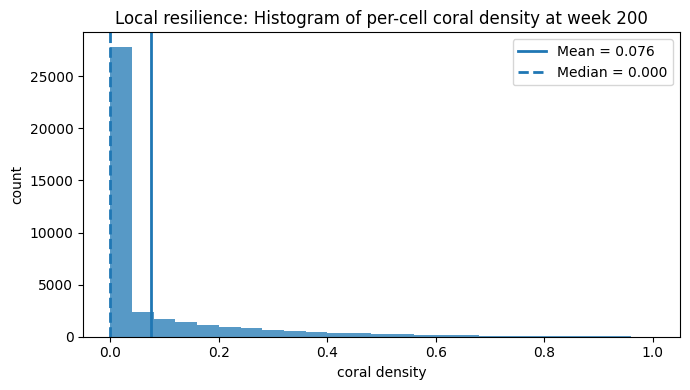

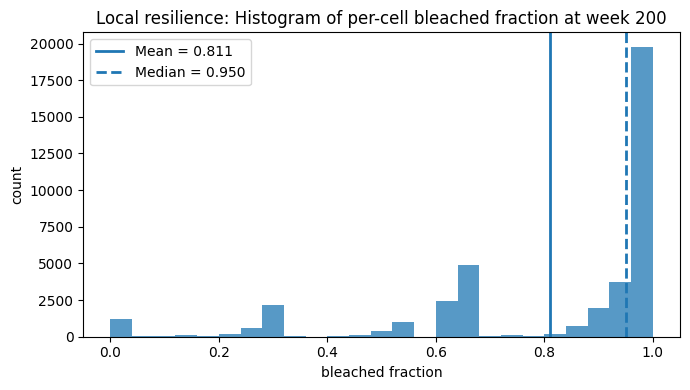


Final mean coral density (week 200)
  Baseline         mean=0.0010  95% CI=(0.0010, 0.0010)
  Runoff reduction mean=0.0023  95% CI=(0.0023, 0.0023)
  Local resilience mean=0.0761  95% CI=(0.0759, 0.0762)

Final live coral area (week 200)
  Baseline         mean=0.0000  95% CI=(0.0000, 0.0000)
  Runoff reduction mean=0.0002  95% CI=(0.0002, 0.0002)
  Local resilience mean=0.1414  95% CI=(0.1409, 0.1418)

Final mean bleached fraction (week 200)
  Baseline         mean=0.9080  95% CI=(0.9078, 0.9083)
  Runoff reduction mean=0.8850  95% CI=(0.8847, 0.8853)
  Local resilience mean=0.8083  95% CI=(0.8079, 0.8086)

Final mortality incidence (proxy) (week 200)
  Baseline         mean=0.7007  95% CI=(0.7000, 0.7014)
  Runoff reduction mean=0.6337  95% CI=(0.6330, 0.6344)
  Local resilience mean=0.4483  95% CI=(0.4475, 0.4492)


In [8]:
#@title Empirical Analysis

# Runs for approximately 3 minutes

# 0) 95% CI for expected value
def mean_ci95(x):
    x = np.asarray(x, dtype=float)
    n = x.size
    mu = x.mean()
    s = x.std(ddof=1) if n > 1 else 0.0
    se = s / np.sqrt(n) if n > 0 else np.nan
    lo = mu - 1.96 * se
    hi = mu + 1.96 * se
    return mu, lo, hi

def band_ci95_of_mean(X):
    """
    X: array shape (N_runs, T+1)
    Returns: mean, lo, hi arrays each shape (T+1)
    """
    X = np.asarray(X, dtype=float)
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=1)
    N = X.shape[0]
    se = std / np.sqrt(N)
    lo = mean - 1.96 * se
    hi = mean + 1.96 * se
    return mean, lo, hi


# 1) Compute metrics per week
def compute_metrics(sim, live_thresh=0.2):
    C = sim.coral
    B = sim.bleached

    mean_coral = C.mean()
    live_area = (C > live_thresh).mean()
    mean_bleached = B.mean()

    dying_now = ((B > sim.bleach_crit) & (sim.bleach_time > sim.death_period))
    mortality_incidence = dying_now.mean()

    return mean_coral, live_area, mean_bleached, mortality_incidence


# 2) Run one simulation and record metrics
def run_one_sim(coral_init, T, seed, params, live_thresh=0.2):
    sim = CoralBleachSim(coral_init, plotting=False, **params)

    # deterministic RNG
    sim.rng = np.random.default_rng(seed)

    sim.initialize()

    sim.acidification = sim.acid_init

    mC = np.zeros(T+1)
    live = np.zeros(T+1)
    mB = np.zeros(T+1)
    mort = np.zeros(T+1)

    # week 0
    mC[0], live[0], mB[0], mort[0] = compute_metrics(sim, live_thresh=live_thresh)

    # weeks 1..T
    for t in range(1, T+1):
        sim.update()
        mC[t], live[t], mB[t], mort[t] = compute_metrics(sim, live_thresh=live_thresh)

    return {
        "mean_coral": mC,
        "live_area": live,
        "mean_bleached": mB,
        "mortality_incidence": mort
    }


# 3) Run Monte Carlo for each scenario
def run_scenario(coral_init, params, T, N, seed0=123, live_thresh=0.2):
    out = {
        "mean_coral": np.zeros((N, T+1)),
        "live_area": np.zeros((N, T+1)),
        "mean_bleached": np.zeros((N, T+1)),
        "mortality_incidence": np.zeros((N, T+1)),
    }

    for i in range(N):
        seed = seed0 + i
        ts = run_one_sim(coral_init, T, seed, params, live_thresh=live_thresh)
        for k in out.keys():
            out[k][i, :] = ts[k]

    return out


# 4) Plotting helpers (bands + points)
def plot_band_with_points(weeks, scenario_data, metric, title, point_every=5):
    """
    Plots mean curve with 95% CI shown as error bars on the mean points.
    """
    plt.figure(figsize=(9, 4))

    for scen_name, data in scenario_data.items():
        mean, lo, hi = band_ci95_of_mean(data[metric])

        # Mean line
        plt.plot(weeks, mean, label=scen_name)

        # Subsample points for readability
        idx = np.arange(0, len(weeks), point_every)
        x = weeks[idx]
        y = mean[idx]
        ci_low = lo[idx]
        ci_high = hi[idx]

        # Error bars for 95% CI
        yerr = np.vstack([y - ci_low, ci_high - y])

        plt.errorbar(
            x, y,
            yerr=yerr,
            fmt='o',
            markersize=3,
            capsize=2,
            elinewidth=2,
            capthick=2,
            linewidth=0
        )

    plt.title(title)
    plt.xlabel("Week")
    plt.ylabel(metric)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_hist_with_mean_median(values, title, xlabel, bins=20):
    """
    Histogram with vertical mean and median lines.
    """
    values = np.asarray(values, dtype=float)
    mu = values.mean()
    med = np.median(values)

    plt.figure(figsize=(7, 4))
    plt.hist(values, bins=bins, alpha=0.75)
    plt.axvline(mu, linewidth=2, linestyle='-', label=f"Mean = {mu:.3f}")
    plt.axvline(med, linewidth=2, linestyle='--', label=f"Median = {med:.3f}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 5) Scenarios (Baseline + 2 interventions)

baseline_params = {}

# Intervention 1: reduce runoff input and frequency
runoff_reduction_params = dict(
    pollution_inflow=0.25,
    pollution_percent=0.10,
    pollution_decay=0.08
)

# Intervention 2: local resilience package (restoration/MPAs/shading proxy)
local_resilience_params = dict(
    recovery_rate=0.35,
    bleach_rate=0.30,
    death_rate=0.03,
    death_period=22,
    growth_rate=0.12,
    alpha=0.55,
    gamma=110
)

scenarios = {
    "Baseline": baseline_params,
    "Runoff reduction": runoff_reduction_params,
    "Local resilience": local_resilience_params,
}


# 6) Run Monte Carlo experiments over 50 trials
T = 200
N = 50
seed0 = 123
weeks = np.arange(T+1)
live_thresh = 0.2

scenario_data = {}
one_run_data = {}

for i, (scen_name, params) in enumerate(scenarios.items()):
    scenario_data[scen_name] = run_scenario(
        ca_grid, params=params, T=T, N=N, seed0=seed0, live_thresh=live_thresh
    )

    # One representative run
    sim = CoralBleachSim(ca_grid, plotting=False, **params)
    sim.rng = np.random.default_rng(seed0 + 999 + i)
    sim.initialize()
    sim.acidification = sim.acid_init

    for _ in range(T):
        sim.update()

    one_run_data[scen_name] = {
        "final_coral_grid": sim.coral.copy(),
        "final_bleached_grid": sim.bleached.copy()
    }


plot_band_with_points(weeks, scenario_data, "mean_coral",
                      "Mean coral density over time (mean ± 95% CI of mean)", point_every=5)

plot_band_with_points(weeks, scenario_data, "live_area",
                      "Live coral area (C > 0.2) over time (mean ± 95% CI of mean)", point_every=5)

plot_band_with_points(weeks, scenario_data, "mean_bleached",
                      "Mean bleached fraction over time (mean ± 95% CI of mean)", point_every=5)

plot_band_with_points(weeks, scenario_data, "mortality_incidence",
                      "Mortality incidence (proxy) over time (mean ± 95% CI of mean)", point_every=5)


# 7) Histograms
for scen_name in scenarios.keys():
    coral_vals = one_run_data[scen_name]["final_coral_grid"].ravel()
    bleached_vals = one_run_data[scen_name]["final_bleached_grid"].ravel()

    plot_hist_with_mean_median(
        coral_vals,
        title=f"{scen_name}: Histogram of per-cell coral density at week {T}",
        xlabel="coral density",
        bins=25
    )

    plot_hist_with_mean_median(
        bleached_vals,
        title=f"{scen_name}: Histogram of per-cell bleached fraction at week {T}",
        xlabel="bleached fraction",
        bins=25
    )


# 9) Final expected values + 95% CI

def print_final_ci(metric_key, label):
    print(f"\n{label} (week {T})")
    for scen_name in scenarios.keys():
        x = scenario_data[scen_name][metric_key][:, -1]   # final values across runs
        mu, lo, hi = mean_ci95(x)
        print(f"  {scen_name:16s} mean={mu:.4f}  95% CI=({lo:.4f}, {hi:.4f})")

print_final_ci("mean_coral", "Final mean coral density")
print_final_ci("live_area", "Final live coral area")
print_final_ci("mean_bleached", "Final mean bleached fraction")
print_final_ci("mortality_incidence", "Final mortality incidence (proxy)")
